In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import torch
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset

#verify Directories - do not need to rerun

In [ ]:
import os
import pandas as pd

# Define base resource path
base_path = "/content/drive/My Drive/LUMT_Thesis_Resources"

# Metadata file path
metadata_path = os.path.join(base_path, "groove_2bar_16000hz_segmented_metadata_all_splits_withaudio_filepath_styleclass_10sec_split_rev_v2.csv") #changed for the new dataset with length_bin column

# Validate that paths exist
print("Checking directories and metadata:")
print(f"Base path exists: {os.path.exists(base_path)}")
print(f"Metadata file exists: {os.path.exists(metadata_path)}")

# Load metadata
metadata = pd.read_csv(metadata_path)

# Confirm required columns exist
assert 'split_rev' in metadata.columns, "'split_rev' column missing in metadata"
assert 'file_path' in metadata.columns, "'file_path' column missing in metadata"

# Preview and verify 3 file paths per split
print("\nChecking sample audio file existence for each split:")
for split in ['train', 'test', 'validation']:
    split_df = metadata[metadata['split_rev'] == split]
    sample_paths = split_df['file_path'].head(3)

    print(f"\n{split.capitalize()} split samples:")
    for rel_path in sample_paths:
        abs_path = os.path.join(base_path, rel_path)
        exists = os.path.exists(abs_path)
        print(f"File exists: {exists} - {abs_path}")


Checking directories and metadata:
Base path exists: True
Metadata file exists: True

Checking sample audio file existence for each split:

Train split samples:
File exists: True - /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session1_78_294.wav
File exists: True - /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer8_session1_2_001.wav
File exists: True - /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session3_5_043.wav

Test split samples:
File exists: True - /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer8_session1_22_087.wav
File exists: True - /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session3_2_160.wav
File exists: True - /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer8_session1_26_053.wav

Validation split samples:
File exists: True - /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_au

Note above how the split_rev is independednt of the original directory structures which was based on the initial split of the data.

This way the model knows to look to the 'split_rev' to get the split then to the 'file_path' to get the exact location.

This is instead of using some logic that assumes the file paths based on combining the base dir + audio folder +file names for example which would be used if the file paths matched the split_rev.

This is crucial to note because it ensure no leakage between splits.

#Verify Class distributions

In [ ]:
import pandas as pd

# Load metadata if not already loaded
metadata = pd.read_csv(metadata_path)

# Ensure column exists
assert 'split_rev' in metadata.columns
assert 'style_class' in metadata.columns

# Extract sorted unique classes
classes = sorted(metadata['style_class'].unique())
num_classes = len(classes)

print(f"Found {num_classes} unique classes: {classes}\n")

# Count total samples per class (entire dataset)
print("Total samples per class:")
total_class_counts = metadata['style_class'].value_counts().loc[classes]
for cls in classes:
    count = total_class_counts[cls]
    print(f"{cls}: {count} samples")

# Split-wise class distribution
print("\nClass distribution in new splits:\n")
for split in ['train', 'validation', 'test']:
    split_df = metadata[metadata['split_rev'] == split]
    total = len(split_df)
    print(f"{split.capitalize()} split:")
    print(f"Total samples: {total}")

    counts = split_df['style_class'].value_counts().reindex(classes, fill_value=0)
    for cls in classes:
        count = counts[cls]
        percent = (count / total) * 100
        print(f"{cls}: {count} samples ({percent:.1f}%)")
    print("")

# Index mapping
print("Class mapping:")
class_to_index = {i: cls for i, cls in enumerate(classes)}
for idx, cls in class_to_index.items():
    print(f"{idx}: {cls}")


Found 74 unique classes: ['afrobeat', 'afrocuban', 'afrocuban_bembe', 'afrocuban_calypso', 'afrocuban_rhumba', 'blues_shuffle', 'country', 'dance_breakbeat', 'dance_disco', 'funk', 'funk_fast', 'funk_groove1', 'funk_groove2', 'funk_groove5', 'funk_latin', 'funk_purdieshuffle', 'funk_rock', 'gospel', 'hiphop', 'hiphop_groove6', 'jazz', 'jazz_fast', 'jazz_funk', 'jazz_fusion', 'jazz_klezmer', 'jazz_linear', 'jazz_march', 'jazz_mediumfast', 'jazz_swing', 'latin', 'latin_ando', 'latin_bomba', 'latin_brazilian', 'latin_brazilian-baiao', 'latin_brazilian-bossa', 'latin_brazilian-frevo', 'latin_brazilian-ijexa', 'latin_brazilian-maracatu', 'latin_brazilian-samba', 'latin_brazilian-sambareggae', 'latin_brazilian-songo', 'latin_chacarera', 'latin_dominican-merengue', 'latin_merengue', 'latin_reggaeton', 'latin_samba', 'latin_venezuelan-joropo', 'latin_venezuelan-merengue', 'latin_venezuelan-sangueo', 'middleeastern', 'neworleans_chacha', 'neworleans_funk', 'neworleans_secondline', 'neworleans_s

#Dataset Class

In [ ]:
# Constants
BASE_DIR = "/content/drive/My Drive/LUMT_Thesis_Resources/"
SAMPLE_RATE = 16_000
CLIP_LENGTH_SAMPLES = SAMPLE_RATE * 10  # 10 seconds = 160000 samples
METADATA_FILE = "groove_2bar_16000hz_segmented_metadata_all_splits_withaudio_filepath_styleclass_10sec_split_rev_v2.csv"
metadata_path = os.path.join(BASE_DIR, METADATA_FILE)

class GrooveDataset(Dataset):
    def __init__(self, split: str):
        assert split in ['train', 'test', 'validation'], f"Invalid split: {split}"

        print(f" Loading metadata from: {metadata_path}")
        df = pd.read_csv(metadata_path)
        print(f" Full metadata loaded: {df.shape[0]} rows")

        # Filter based on revised split
        df = df[df['split_rev'] == split].reset_index(drop=True) #new dataframe per split
        print(f" Subset for '{split}' split: {df.shape[0]} rows")

        # Check required columns
        assert 'file_path' in df.columns, "Missing 'file_path' in metadata"
        assert 'style_class' in df.columns, "Missing 'style_class' in metadata"

        # Convert relative paths to absolute
        df['file_path'] = df['file_path'].apply(lambda x: os.path.join(BASE_DIR, x))

        # Store processed dataframe
        self.data_df = df

        # Build label mapping
        self.labels = sorted(df["style_class"].unique())
        self.class_to_idx = {label: idx for idx, label in enumerate(self.labels)}

        print(" Available classes and mapping:")
        for idx, label in self.class_to_idx.items():
            print(f"  {label}: {idx}")

        # Preview head
        print(" Preview of dataset:")
        print(self.data_df[['file_path', 'style_class']].head(3))

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        row = self.data_df.iloc[idx]
        file_path = row["file_path"]
        label = row["style_class"]

        try:
            waveform, sr = torchaudio.load(file_path)

            # Resample if needed
            if sr != SAMPLE_RATE:
                print(f"[RESAMPLE] {file_path}: {sr}Hz → {SAMPLE_RATE}Hz")
                resampler = T.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)
                waveform = resampler(waveform)

            # Convert to mono
            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0, keepdim=True)

            num_samples = waveform.size(1)
            print(f"[AUDIO] {file_path} | Original samples: {num_samples}")

            if num_samples < CLIP_LENGTH_SAMPLES:
                waveform = F.pad(waveform, (0, CLIP_LENGTH_SAMPLES - num_samples))
                print(f"[PADDED] Padded to {CLIP_LENGTH_SAMPLES}")
            else:
                waveform = waveform[:, :CLIP_LENGTH_SAMPLES]
                print(f"[TRIMMED] Trimmed to {CLIP_LENGTH_SAMPLES}")

            label_index = self.class_to_idx[label]
            return waveform, label_index, SAMPLE_RATE

        except Exception as e:
            print(f"[ERROR] Failed loading {file_path}: {e}")
            return None

# --- Instantiate all splits below ---

print(" Instantiating all dataset splits...\n")
train_dataset = GrooveDataset(split="train")
val_dataset = GrooveDataset(split="validation")
test_dataset = GrooveDataset(split="test")

# Print sizes
print(f" Dataset sizes:")
print(f"Train: {len(train_dataset)} samples")
print(f"Validation: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

# Trigger sample loading for verification
print(f" Triggering 1 sample from each split for verification:")
_ = train_dataset[0]
_ = val_dataset[0]
_ = test_dataset[0]


 Instantiating all dataset splits...

 Loading metadata from: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_16000hz_segmented_metadata_all_splits_withaudio_filepath_styleclass_10sec_split_rev_v2.csv
 Full metadata loaded: 18264 rows
 Subset for 'train' split: 14611 rows
 Available classes and mapping:
  0: afrobeat
  1: afrocuban
  2: afrocuban_bembe
  3: afrocuban_calypso
  4: afrocuban_rhumba
  5: blues_shuffle
  6: country
  7: dance_breakbeat
  8: dance_disco
  9: funk
  10: funk_fast
  11: funk_groove1
  12: funk_groove2
  13: funk_groove5
  14: funk_latin
  15: funk_purdieshuffle
  16: funk_rock
  17: gospel
  18: hiphop
  19: hiphop_groove6
  20: jazz
  21: jazz_fast
  22: jazz_funk
  23: jazz_fusion
  24: jazz_klezmer
  25: jazz_linear
  26: jazz_march
  27: jazz_mediumfast
  28: jazz_swing
  29: latin
  30: latin_ando
  31: latin_bomba
  32: latin_brazilian
  33: latin_brazilian-baiao
  34: latin_brazilian-bossa
  35: latin_brazilian-frevo
  36: latin_brazilian-ije

#Sanity Checks for datasets

In [ ]:
# Sanity check: trigger 3 samples per dataset after instantiation

print(" Running sanity check: first 3 samples from each split\n")

dataset_dict = {
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
}

for split_name, dataset in dataset_dict.items():
    print(f" Split: {split_name.upper()}")
    print(f"Size: {len(dataset)} samples")

    for i in range(3):
        print(f" Sample {i+1}:")
        _ = dataset[i]

 Running sanity check: first 3 samples from each split

 Split: TRAIN
Size: 14611 samples
 Sample 1:
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session1_78_294.wav | Original samples: 26483
[PADDED] Padded to 160000
 Sample 2:
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer8_session1_2_001.wav | Original samples: 80842
[PADDED] Padded to 160000
 Sample 3:
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session3_5_043.wav | Original samples: 60000
[PADDED] Padded to 160000
 Split: VALIDATION
Size: 1826 samples
 Sample 1:
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer7_session2_64_040.wav | Original samples: 52965
[PADDED] Padded to 160000
 Sample 2:
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer5_session2_6_065.wav | Original samples: 77575
[PADDED] Padded to 160000
 Sample 3:
[AUDIO] /conte

In [ ]:
# Enhanced debug: Inspect waveform, label, and metadata for 3 samples per split

print(" Detailed shape and label check per split...\n")

dataset_dict = {
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
}

for split_name, dataset in dataset_dict.items():
    print(f" SPLIT: {split_name.upper()}")
    for i in range(3):
        print(f" Sample {i+1}:")

        # Load waveform, label index, sample rate
        sample_waveform, sample_label_idx, sample_rate = dataset[i]

        # Get corresponding metadata
        row = dataset.data_df.iloc[i]
        split_rev = row['split_rev']
        file_path = row['file_path']
        style_class = row['style_class']

        # Print info
        print(f"  ➤ split_rev     : {split_rev}")
        print(f"  ➤ file_path     : {file_path}")
        print(f"  ➤ style_class   : {style_class}")
        print(f"  ➤ label index   : {sample_label_idx}")
        print(f"  ➤ waveform shape: {sample_waveform.shape}")
        print(f"  ➤ sample rate   : {sample_rate}")


 Detailed shape and label check per split...

 SPLIT: TRAIN
 Sample 1:
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session1_78_294.wav | Original samples: 26483
[PADDED] Padded to 160000
  ➤ split_rev     : train
  ➤ file_path     : /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session1_78_294.wav
  ➤ style_class   : jazz_fast
  ➤ label index   : 21
  ➤ waveform shape: torch.Size([1, 160000])
  ➤ sample rate   : 16000
 Sample 2:
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer8_session1_2_001.wav | Original samples: 80842
[PADDED] Padded to 160000
  ➤ split_rev     : train
  ➤ file_path     : /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer8_session1_2_001.wav
  ➤ style_class   : funk
  ➤ label index   : 9
  ➤ waveform shape: torch.Size([1, 160000])
  ➤ sample rate   : 16000
 Sample 3:
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_

#Waveform Features class and verify Feature Extraction

In [ ]:
import torch.nn as nn
import torchaudio.transforms as T

class WaveformFeatures(nn.Module):
    def __init__(
        self,
        sample_rate=16_000,
        n_fft=1024,
        n_mels=128,
        power=2.0, #default value
    ):
        super().__init__()
        hop_length = n_fft // 4

        self.spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=power)
        self.mel_scale = T.MelScale(n_mels=n_mels, sample_rate=sample_rate, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # waveform: (1, N)
        spec = self.spectrogram(waveform)  # (1, F, T)
        mel_spec = self.mel_scale(spec)    # (1, M, T)
        return mel_spec


In [ ]:
# Feature extraction test on real dataset sample
print(" Verifying Mel Spectrogram extraction pipeline...")

# Use existing train_dataset (already filtered, padded)
sample_waveform, sample_label_idx, sample_rate = train_dataset[0]

print(f"Input waveform shape: {sample_waveform.shape}")
print(f"Sample rate: {sample_rate}")
print(f"Label index: {sample_label_idx}")
print(f"Original class: {train_dataset.data_df.iloc[0]['style_class']}")
print(f"From file: {train_dataset.data_df.iloc[0]['file_path']}")

# Instantiate feature extractor
feature_extractor = WaveformFeatures(sample_rate=sample_rate)

# Generate log-mel spectrogram
mel_spectrogram = feature_extractor(sample_waveform)

# Print output shape
print(f" Mel Spectrogram shape: {mel_spectrogram.shape}")


 Verifying Mel Spectrogram extraction pipeline...
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer8_session1_26_025.wav | Original samples: 81702
[PADDED] Padded to 160000
Input waveform shape: torch.Size([1, 160000])
Sample rate: 16000
Label index: 0
Original class: afrobeat
From file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer8_session1_26_025.wav
 Mel Spectrogram shape: torch.Size([1, 128, 626])


#DataLoader

In [ ]:
from torch.utils.data import DataLoader

# Hyperparameters
BATCH_SIZE = 16
NUM_WORKERS = 0  # Safe default for Colab

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("DataLoaders created")

# Sample batch from train loader to verify shapes
print("Inspecting one batch from train_loader...")

batch = next(iter(train_loader))
waveforms, labels, sample_rates = batch

print(f"Waveform batch shape : {waveforms.shape}  # Expect: [B, 1, 160000]")
print(f"Labels shape         : {labels.shape}     # Expect: [B]")
print(f"Sample rates         : {sample_rates}")    # Should all be 16000


DataLoaders created
Inspecting one batch from train_loader...
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer4_session1_6_002.wav | Original samples: 57313
[PADDED] Padded to 160000
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer5_session1_9_143.wav | Original samples: 59076
[PADDED] Padded to 160000
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session1_78_179.wav | Original samples: 26483
[PADDED] Padded to 160000
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_test/drummer5_session1_7_020.wav | Original samples: 80000
[PADDED] Padded to 160000
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer5_session2_23_043.wav | Original samples: 64000
[PADDED] Padded to 160000
[AUDIO] /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer5_session1_8_015.wav | Original samples: 59259
[PADDED] Padded

#Updated GrooveDataset with Feature Extraction (Dataset Class)

In [ ]:
class GrooveDataset(Dataset):
    def __init__(self, split: str, transform=None):
        assert split in ['train', 'test', 'validation'], f"Invalid split: {split}"
        self.transform = transform

        print(f" Loading metadata from: {metadata_path}")
        df = pd.read_csv(metadata_path)
        print(f" Full metadata loaded: {df.shape[0]} rows")

        df = df[df['split_rev'] == split].reset_index(drop=True)
        print(f" Subset for '{split}' split: {df.shape[0]} rows")

        assert 'file_path' in df.columns
        assert 'style_class' in df.columns

        df['file_path'] = df['file_path'].apply(lambda x: os.path.join(BASE_DIR, x))
        self.data_df = df

        self.labels = sorted(df["style_class"].unique())
        self.class_to_idx = {label: idx for idx, label in enumerate(self.labels)}

        print(" Available classes and mapping:")
        for idx, label in self.class_to_idx.items():
            print(f"  {label}: {idx}")

        print(" Preview of dataset:")
        print(self.data_df[['file_path', 'style_class']].head(3))

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        row = self.data_df.iloc[idx]
        file_path = row["file_path"]
        label = row["style_class"]

        try:
            waveform, sr = torchaudio.load(file_path)

            if sr != SAMPLE_RATE:
                print(f"[RESAMPLE] {file_path}: {sr}Hz → {SAMPLE_RATE}Hz")
                resampler = T.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)
                waveform = resampler(waveform)

            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0, keepdim=True)

            num_samples = waveform.size(1)
            print(f"[AUDIO] {file_path} | Original samples: {num_samples}")

            if num_samples < CLIP_LENGTH_SAMPLES:
                waveform = F.pad(waveform, (0, CLIP_LENGTH_SAMPLES - num_samples))
                print(f"[PADDED] Padded to {CLIP_LENGTH_SAMPLES}")
            else:
                waveform = waveform[:, :CLIP_LENGTH_SAMPLES]
                print(f"[TRIMMED] Trimmed to {CLIP_LENGTH_SAMPLES}")

            # APPLY MEL FEATURE EXTRACTOR HERE
            if self.transform:
                features = self.transform(waveform)  # Expect [1, 128, T]
            else:
                features = waveform  # Raw waveform fallback

            label_index = self.class_to_idx[label]
            return features, label_index, SAMPLE_RATE

        except Exception as e:
            print(f"[ERROR] Failed loading {file_path}: {e}")
            return None


#DATALOADER W/ MEL FEATURES + DEBUG PRINTS

In [ ]:
# Instantiate feature extractor
feature_extractor = WaveformFeatures(sample_rate=16000)

# Create dataset objects with mel spectrogram transform
train_dataset = GrooveDataset(split="train", transform=feature_extractor)
val_dataset   = GrooveDataset(split="validation", transform=feature_extractor)
test_dataset  = GrooveDataset(split="test", transform=feature_extractor)

# Create dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test a sample batch
print("Testing first batch from train_loader...\n")
batch = next(iter(train_loader))

batch_features, batch_labels, batch_sample_rates = batch

print(f"Waveform batch shape: {batch_features.shape}")  # [B, 1, 128, T]
print(f"Label indices       : {batch_labels}")
print(f"Sample rates        : {batch_sample_rates}")

# Optional: print label names
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
label_names = [idx_to_class[i.item()] for i in batch_labels]
print(f"Label names         : {label_names}")


 Loading metadata from: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_16000hz_segmented_metadata_all_splits_withaudio_filepath_styleclass_10sec_split_rev_v2.csv
 Full metadata loaded: 18264 rows
 Subset for 'train' split: 14611 rows
 Available classes and mapping:
  0: afrobeat
  1: afrocuban
  2: afrocuban_bembe
  3: afrocuban_calypso
  4: afrocuban_rhumba
  5: blues_shuffle
  6: country
  7: dance_breakbeat
  8: dance_disco
  9: funk
  10: funk_fast
  11: funk_groove1
  12: funk_groove2
  13: funk_groove5
  14: funk_latin
  15: funk_purdieshuffle
  16: funk_rock
  17: gospel
  18: hiphop
  19: hiphop_groove6
  20: jazz
  21: jazz_fast
  22: jazz_funk
  23: jazz_fusion
  24: jazz_klezmer
  25: jazz_linear
  26: jazz_march
  27: jazz_mediumfast
  28: jazz_swing
  29: latin
  30: latin_ando
  31: latin_bomba
  32: latin_brazilian
  33: latin_brazilian-baiao
  34: latin_brazilian-bossa
  35: latin_brazilian-frevo
  36: latin_brazilian-ijexa
  37: latin_brazilian-maracatu
  38

# DrumStyleClassifier CNN Module

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DrumStyleClassifier(nn.Module):
    def __init__(self, num_classes, n_mel=128):
        super(DrumStyleClassifier, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Adaptive Global Average Pooling to flatten time axis dynamically
        self.global_pool = nn.AdaptiveAvgPool2d((n_mel // 8, 1))  # Reduce to [batch, channels, mel/8, 1]

        # Fully connected layers
        fc_input_dim = 64 * (n_mel // 8) * 1
        self.fc1 = nn.Linear(fc_input_dim, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [B, 16, 64, T/2]
        x = self.pool(F.relu(self.conv2(x)))  # -> [B, 32, 32, T/4]
        x = self.pool(F.relu(self.conv3(x)))  # -> [B, 64, 16, T/8]

        x = self.global_pool(x)               # -> [B, 64, mel/8, 1]
        x = x.view(x.size(0), -1)             # Flatten

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


#Consolidated Model Code

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader

# === Constants ===
BASE_DIR = "/content/drive/My Drive/LUMT_Thesis_Resources/"
SAMPLE_RATE = 16_000
CLIP_LENGTH_SAMPLES = SAMPLE_RATE * 10  # 10 seconds = 160000 samples
METADATA_FILE = "groove_2bar_16000hz_segmented_metadata_all_splits_withaudio_filepath_styleclass_10sec_split_rev_v2.csv"
metadata_path = os.path.join(BASE_DIR, METADATA_FILE)

# === Mel Feature Extractor ===
class WaveformFeatures(nn.Module):
    def __init__(self, sample_rate=16000, n_fft=1024, n_mels=128):
        super().__init__()
        hop_length = n_fft // 4
        self.spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=2.0)
        self.mel_scale = T.MelScale(n_mels=n_mels, sample_rate=sample_rate, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        spec = self.spectrogram(waveform)
        mel_spec = self.mel_scale(spec)
        return mel_spec

# === Dataset Class with Mel Transform Support ===
class GrooveDataset(Dataset):
    def __init__(self, split: str, transform=None):
        assert split in ['train', 'test', 'validation'], f"Invalid split: {split}"
        self.transform = transform

        df = pd.read_csv(metadata_path)
        df = df[df['split_rev'] == split].reset_index(drop=True)
        df['file_path'] = df['file_path'].apply(lambda x: os.path.join(BASE_DIR, x))

        self.data_df = df
        self.labels = sorted(df["style_class"].unique())
        self.class_to_idx = {label: idx for idx, label in enumerate(self.labels)}
        self.idx_to_class = {idx: label for label, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        row = self.data_df.iloc[idx]
        file_path = row["file_path"]
        label = row["style_class"]

        try:
            waveform, sr = torchaudio.load(file_path)
            if sr != SAMPLE_RATE:
                resampler = T.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)
                waveform = resampler(waveform)

            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0, keepdim=True)

            num_samples = waveform.size(1)
            if num_samples < CLIP_LENGTH_SAMPLES:
                waveform = F.pad(waveform, (0, CLIP_LENGTH_SAMPLES - num_samples))
            else:
                waveform = waveform[:, :CLIP_LENGTH_SAMPLES]

            if self.transform:
                features = self.transform(waveform)
            else:
                features = waveform

            label_index = self.class_to_idx[label]
            return features, label_index, SAMPLE_RATE

        except Exception as e:
            print(f"[ERROR] Failed loading {file_path}: {e}")
            return None

# === CNN Classifier with Adaptive Pooling ===
class DrumStyleClassifier(nn.Module):
    def __init__(self, num_classes, n_mel=128):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Reduce time dimension to 1; keep mel dim compressed to 16
        self.global_pool = nn.AdaptiveAvgPool2d((n_mel // 8, 1))  # → (16, 1)

        self.fc1 = nn.Linear(64 * (n_mel // 8) * 1, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, 64, T/2]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, 32, T/4]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 64, 16, T/8]
        x = self.global_pool(x)               # → [B, 64, 16, 1]
        x = x.view(x.size(0), -1)             # Flatten to [B, 1024]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


#Dataloaders

run after consolidated model code

In [ ]:
# Instantiate feature extractor
feature_extractor = WaveformFeatures(sample_rate=16000)

# Create datasets w/ transform
train_dataset = GrooveDataset(split="train", transform=feature_extractor)
val_dataset   = GrooveDataset(split="validation", transform=feature_extractor)
test_dataset  = GrooveDataset(split="test", transform=feature_extractor)

# Create DataLoaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Optional: inspect 1 batch
batch = next(iter(train_loader))
features, labels, sample_rates = batch
print(f"Batch shape: {features.shape}, Labels: {labels}")


Batch shape: torch.Size([16, 1, 128, 626]), Labels: tensor([18, 20,  7, 68,  0, 21, 60,  8, 20, 20,  0,  9, 60, 14, 28,  7])


#Device Setup for Training

In [ ]:
# === Device configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")


 Using device: cuda


#Instantiate the model

In [ ]:
model = DrumStyleClassifier(num_classes=len(train_dataset.class_to_idx))
model = model.to(device)

#Training setup

In [ ]:
import os
import csv
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# === SETTINGS ===
CHECKPOINTS_DIR = "checkpoints"
LOG_CSV = "gmd_cnn_p5_log.csv"  # Updated log file name
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

# === One epoch of train or val ===
def run_epoch(model, loader, criterion, optimizer, device, is_training):
    model.train() if is_training else model.eval()

    total_loss, correct, total = 0, 0, 0
    all_losses = []

    for features, labels, _ in tqdm(loader, desc="Train" if is_training else "Val", leave=False):
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        all_losses.append(loss.item())

        # Accuracy
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy, all_losses

# === Save current model state ===
def save_checkpoint(model, optimizer, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

# === Train full model with early stopping ===
def train_model(model, train_loader, val_loader, criterion, optimizer, device,
                max_epochs=50, patience=10):
    """
    Trains model and tracks:
      - train/val loss per batch & epoch
      - val accuracy per epoch
      - early stopping based on val accuracy
      - saves best model to disk
      - logs all epochs to CSV
    """

    best_val_acc = 0.0
    patience_counter = 0
    all_train_losses, all_val_losses = [], []
    all_val_accuracies = []

    # === Initialize CSV ===
    with open(LOG_CSV, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "val_loss", "val_accuracy"])

    for epoch in range(1, max_epochs + 1):
        print(f"Epoch {epoch}/{max_epochs}")

        # === Train / Validate
        train_loss, train_acc, train_losses = run_epoch(model, train_loader, criterion, optimizer, device, True)
        val_loss, val_acc, val_losses = run_epoch(model, val_loader, criterion, optimizer, device, False)

        # === Print summary for this epoch
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_val_accuracies.append(val_acc)

        # === Append to CSV
        with open(LOG_CSV, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, train_loss, val_loss, val_acc])

        # === Early Stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_path = f"{CHECKPOINTS_DIR}/best_model_epoch_{epoch}.pth"
            save_checkpoint(model, optimizer, epoch, best_model_path)
            print(f" New best model saved at: {best_model_path}")
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return all_train_losses, all_val_losses, all_val_accuracies



#Training Execution

In [ ]:
# === Instantiate model and training components ===
model = DrumStyleClassifier(num_classes=len(train_dataset.class_to_idx)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# === Run training with early stopping & return model path
train_losses, val_losses, val_accuracies, best_model_path = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    max_epochs=50,
    patience=10
)

# === Plot Loss + Validation Accuracy
epochs = list(range(1, len(val_accuracies) + 1))
train_loss_avg = [np.mean(epoch) for epoch in train_losses]
val_loss_avg = [np.mean(epoch) for epoch in val_losses]

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_avg, label="Train Loss", marker='o', color='blue')
plt.plot(epochs, val_loss_avg, label="Validation Loss", marker='o', color='red')
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='s', color='green')

plt.title("Training Progress: Loss & Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.grid(True)
plt.legend()
plt.savefig("loss_accuracy_plot.png", dpi=300, bbox_inches="tight")
plt.show()

# === Final training output
print("Training complete.")
print(f"Best model saved to: {best_model_path}")
print("Log CSV saved to: gmd_cnn_p5_log.csv")
print("  Plot saved to: loss_accuracy_plot.png")



Epoch 1/50


Train Loss: 3.2990 | Val Loss: 2.8914 | Val Acc: 0.2426
 New best model saved at: checkpoints/best_model_epoch_1.pth
Epoch 2/50


Train Loss: 2.8906 | Val Loss: 2.6793 | Val Acc: 0.2809
 New best model saved at: checkpoints/best_model_epoch_2.pth
Epoch 3/50


Train Loss: 2.6943 | Val Loss: 2.4687 | Val Acc: 0.3187
 New best model saved at: checkpoints/best_model_epoch_3.pth
Epoch 4/50


Train Loss: 2.5369 | Val Loss: 2.3267 | Val Acc: 0.3412
 New best model saved at: checkpoints/best_model_epoch_4.pth
Epoch 5/50


Train Loss: 2.4097 | Val Loss: 2.1864 | Val Acc: 0.3740
 New best model saved at: checkpoints/best_model_epoch_5.pth
Epoch 6/50


Train Loss: 2.2858 | Val Loss: 2.0910 | Val Acc: 0.3855
 New best model saved at: checkpoints/best_model_epoch_6.pth
Epoch 7/50


Train Loss: 2.1972 | Val Loss: 2.0020 | Val Acc: 0.4151
 New best model saved at: checkpoints/best_model_epoch_7.pth
Epoch 8/50


Train Loss: 2.1230 | Val Loss: 1.9200 | Val Acc: 0.4195
 New best model saved at: checkpoints/best_model_epoch_8.pth
Epoch 9/50


Train Loss: 2.0443 | Val Loss: 1.8499 | Val Acc: 0.4556
 New best model saved at: checkpoints/best_model_epoch_9.pth
Epoch 10/50


Train Loss: 1.9871 | Val Loss: 1.7899 | Val Acc: 0.4704
 New best model saved at: checkpoints/best_model_epoch_10.pth
Epoch 11/50


Train Loss: 1.9217 | Val Loss: 1.7316 | Val Acc: 0.4907
 New best model saved at: checkpoints/best_model_epoch_11.pth
Epoch 12/50


Train Loss: 1.8732 | Val Loss: 1.6899 | Val Acc: 0.4984
 New best model saved at: checkpoints/best_model_epoch_12.pth
Epoch 13/50


Train Loss: 1.8160 | Val Loss: 1.6468 | Val Acc: 0.5340
 New best model saved at: checkpoints/best_model_epoch_13.pth
Epoch 14/50


Train Loss: 1.7593 | Val Loss: 1.6317 | Val Acc: 0.5208
Patience: 1/10
Epoch 15/50


Train Loss: 1.7185 | Val Loss: 1.5318 | Val Acc: 0.5372
 New best model saved at: checkpoints/best_model_epoch_15.pth
Epoch 16/50


Train Loss: 1.6727 | Val Loss: 1.5168 | Val Acc: 0.5487
 New best model saved at: checkpoints/best_model_epoch_16.pth
Epoch 17/50


Train Loss: 1.6359 | Val Loss: 1.4839 | Val Acc: 0.5460
Patience: 1/10
Epoch 18/50


Train Loss: 1.5973 | Val Loss: 1.4372 | Val Acc: 0.5663
 New best model saved at: checkpoints/best_model_epoch_18.pth
Epoch 19/50


Train Loss: 1.5597 | Val Loss: 1.4028 | Val Acc: 0.5805
 New best model saved at: checkpoints/best_model_epoch_19.pth
Epoch 20/50


Train Loss: 1.5235 | Val Loss: 1.3739 | Val Acc: 0.5920
 New best model saved at: checkpoints/best_model_epoch_20.pth
Epoch 21/50


Train Loss: 1.4897 | Val Loss: 1.3594 | Val Acc: 0.5920
Patience: 1/10
Epoch 22/50


Train Loss: 1.4578 | Val Loss: 1.3211 | Val Acc: 0.5958
 New best model saved at: checkpoints/best_model_epoch_22.pth
Epoch 23/50


Train Loss: 1.4162 | Val Loss: 1.2864 | Val Acc: 0.6062
 New best model saved at: checkpoints/best_model_epoch_23.pth
Epoch 24/50


Train Loss: 1.3826 | Val Loss: 1.2728 | Val Acc: 0.6249
 New best model saved at: checkpoints/best_model_epoch_24.pth
Epoch 25/50


Train Loss: 1.3674 | Val Loss: 1.2174 | Val Acc: 0.6407
 New best model saved at: checkpoints/best_model_epoch_25.pth
Epoch 26/50


Train Loss: 1.3436 | Val Loss: 1.2239 | Val Acc: 0.6314
Patience: 1/10
Epoch 27/50


Train Loss: 1.3128 | Val Loss: 1.1948 | Val Acc: 0.6462
 New best model saved at: checkpoints/best_model_epoch_27.pth
Epoch 28/50


Train Loss: 1.2918 | Val Loss: 1.2071 | Val Acc: 0.6325
Patience: 1/10
Epoch 29/50


Train Loss: 1.2556 | Val Loss: 1.1535 | Val Acc: 0.6495
 New best model saved at: checkpoints/best_model_epoch_29.pth
Epoch 30/50


Train Loss: 1.2378 | Val Loss: 1.1256 | Val Acc: 0.6687
 New best model saved at: checkpoints/best_model_epoch_30.pth
Epoch 31/50


Train Loss: 1.2185 | Val Loss: 1.1016 | Val Acc: 0.6659
Patience: 1/10
Epoch 32/50


Train Loss: 1.1977 | Val Loss: 1.1145 | Val Acc: 0.6665
Patience: 2/10
Epoch 33/50


Train Loss: 1.1747 | Val Loss: 1.0675 | Val Acc: 0.6829
 New best model saved at: checkpoints/best_model_epoch_33.pth
Epoch 34/50


Train Loss: 1.1530 | Val Loss: 1.0641 | Val Acc: 0.6813
Patience: 1/10
Epoch 35/50


Train Loss: 1.1363 | Val Loss: 1.0251 | Val Acc: 0.6972
 New best model saved at: checkpoints/best_model_epoch_35.pth
Epoch 36/50


Train Loss: 1.1008 | Val Loss: 1.0204 | Val Acc: 0.6982
 New best model saved at: checkpoints/best_model_epoch_36.pth
Epoch 37/50


Train Loss: 1.0977 | Val Loss: 1.0106 | Val Acc: 0.6982
Patience: 1/10
Epoch 38/50


Train Loss: 1.0632 | Val Loss: 1.0018 | Val Acc: 0.6944
Patience: 2/10
Epoch 39/50


Train Loss: 1.0634 | Val Loss: 0.9809 | Val Acc: 0.6977
Patience: 3/10
Epoch 40/50


Train Loss: 1.0315 | Val Loss: 0.9792 | Val Acc: 0.7103
 New best model saved at: checkpoints/best_model_epoch_40.pth
Epoch 41/50


Train Loss: 1.0219 | Val Loss: 0.9293 | Val Acc: 0.7158
 New best model saved at: checkpoints/best_model_epoch_41.pth
Epoch 42/50


Train Loss: 0.9962 | Val Loss: 0.9442 | Val Acc: 0.7163
 New best model saved at: checkpoints/best_model_epoch_42.pth
Epoch 43/50


Train Loss: 0.9887 | Val Loss: 0.9256 | Val Acc: 0.7147
Patience: 1/10
Epoch 44/50


Train Loss: 0.9686 | Val Loss: 0.9228 | Val Acc: 0.7229
 New best model saved at: checkpoints/best_model_epoch_44.pth
Epoch 45/50


Train Loss: 0.9629 | Val Loss: 0.8701 | Val Acc: 0.7448
 New best model saved at: checkpoints/best_model_epoch_45.pth
Epoch 46/50


Train Loss: 0.9442 | Val Loss: 0.8961 | Val Acc: 0.7278
Patience: 1/10
Epoch 47/50


Train Loss: 0.9215 | Val Loss: 0.8562 | Val Acc: 0.7492
 New best model saved at: checkpoints/best_model_epoch_47.pth
Epoch 48/50


Train Loss: 0.9075 | Val Loss: 0.8501 | Val Acc: 0.7437
Patience: 1/10
Epoch 49/50


Train Loss: 0.8974 | Val Loss: 0.8669 | Val Acc: 0.7366
Patience: 2/10
Epoch 50/50


Train Loss: 0.8885 | Val Loss: 0.8153 | Val Acc: 0.7492
Patience: 3/10


ValueError: not enough values to unpack (expected 4, got 3)

^ above results show best at epoch 50, downloaded the top 3 epochs to save to google drive. (50,46,37)

Error was thrown when trying to visualize training not in the training itself, for future iterations, edit this cell to exclude training visualization and just execute the training.

#Prevent timeout script

In [ ]:
%%javascript
function preventIdle() {
    setInterval(() => {
        console.log("Preventing Colab Disconnect...");
        document.querySelector("colab-toolbar-button")?.click();
    }, 60000); // Clicks every 60 seconds
}
preventIdle();

#Visualize the training

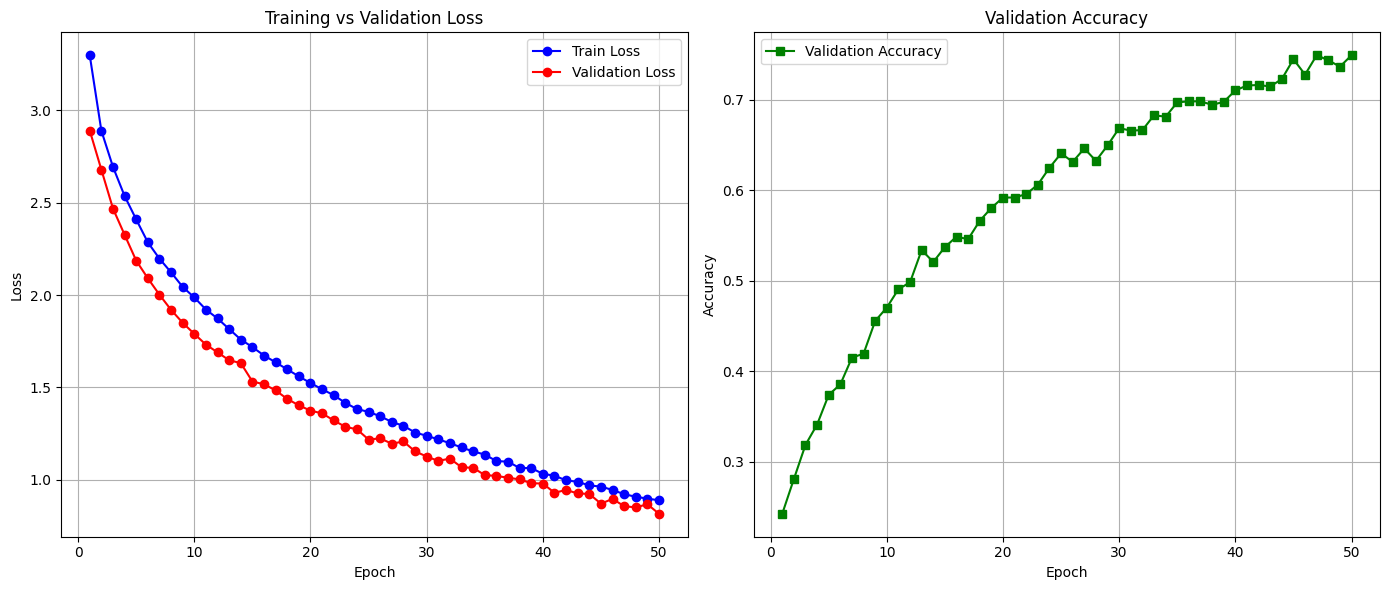

Training visualization complete.
Plot saved as: loss_accuracy_plot.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Path to training log in Colab runtime
log_path = "gmd_cnn_p5_log.csv"

# === Load training log
log_df = pd.read_csv(log_path)

# === Extract columns
epochs = log_df["epoch"]
train_loss = log_df["train_loss"]
val_loss = log_df["val_loss"]
val_acc = log_df["val_accuracy"]

# === Plot loss and accuracy
plt.figure(figsize=(14, 6))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", color='blue', marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", color='red', marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc, label="Validation Accuracy", color='green', marker='s')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Save & show plot
plt.tight_layout()
plt.savefig("loss_accuracy_plot.png", dpi=300, bbox_inches="tight")
plt.show()

print("Training visualization complete.")
print("Plot saved as: loss_accuracy_plot.png")



^^ Above seems training could have continued maybe another 30 epochs before validaion accuracy would have flattened out around 0.8

#Reload the Model and Load Weights

In [ ]:
# === Rebuild model and load best weights ===
model = DrumStyleClassifier(num_classes=len(train_dataset.class_to_idx)).to(device)

# Load best checkpoint
best_model_path = "checkpoints/best_model_epoch_47.pth"
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f"Model loaded from: {best_model_path}")


Model loaded from: checkpoints/best_model_epoch_47.pth


#note

Ran inference with epoch 47 but should have been 50? I don't think the checkpoints saved the 50th epoch because the validation accuracy matches epoch 47 but the  train/val loss were lower. Is this an issue? Need to retrain? (note there is no best model saved note after epoch 50 finished

Epoch 50/50
Train Loss: 0.8885 | Val Loss: 0.8153 | Val Acc: 0.7492
Patience: 3/10


Epoch 47/50
Train Loss: 0.9215 | Val Loss: 0.8562 | Val Acc: 0.7492
 New best model saved at: checkpoints/best_model_epoch_47.pth

#Reload Test set

In [ ]:
# === Recreate test set loader ===
test_dataset = GrooveDataset(split="test", transform=feature_extractor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Test dataset size: {len(test_dataset)}")


Test dataset size: 1827


#Inference , Confusion Matrix, Report

confusion matrix plots correctly


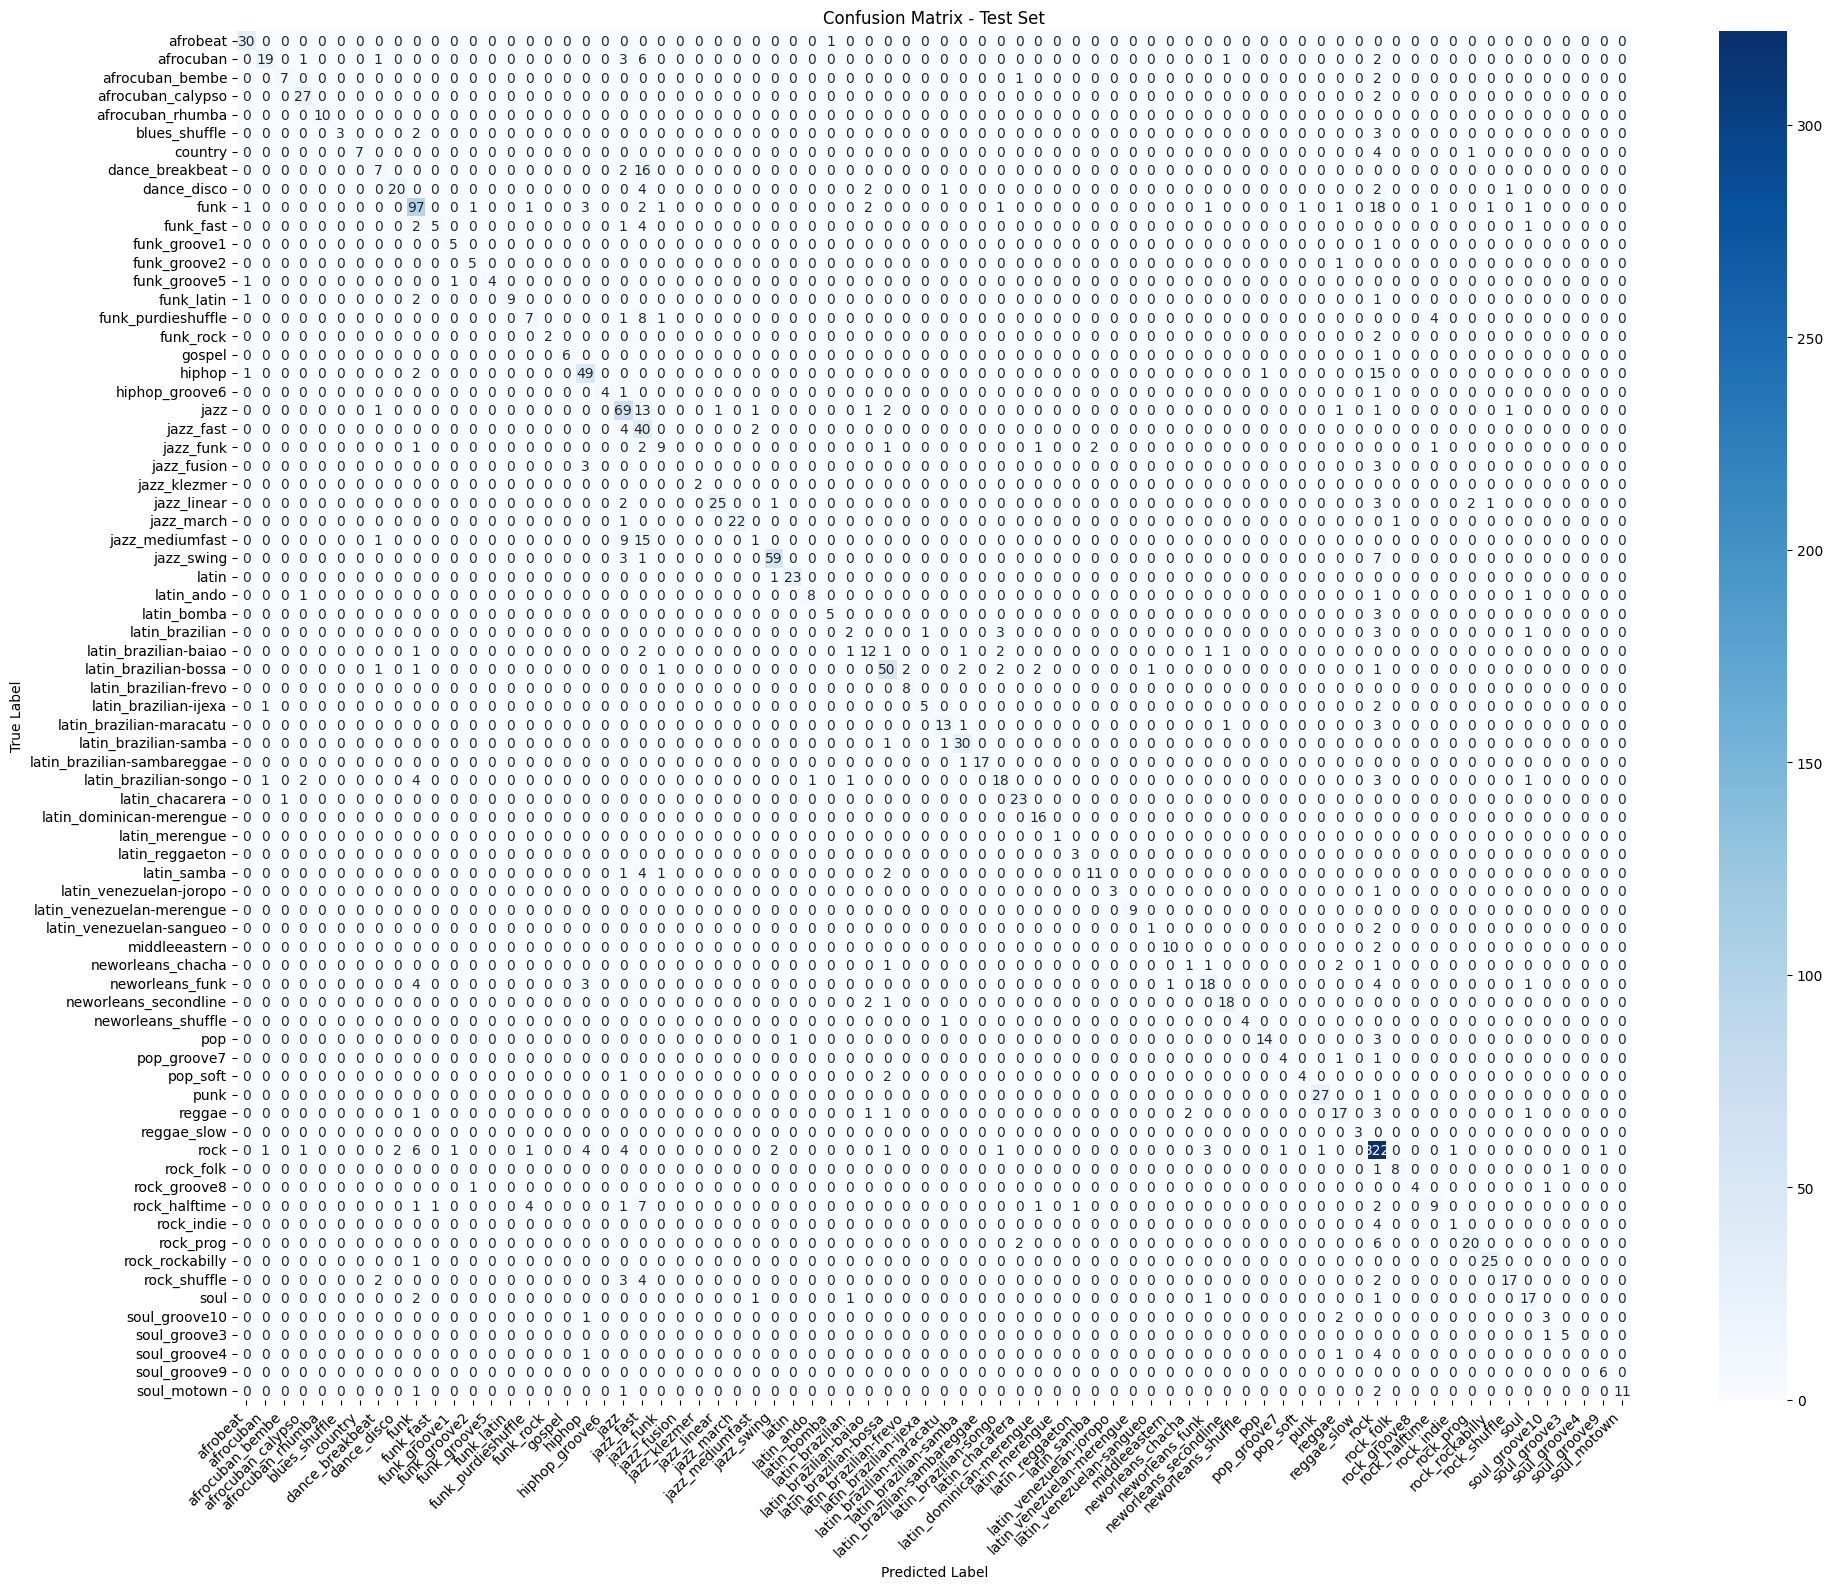

Classification Report:

                             precision    recall  f1-score   support

                   afrobeat       0.88      0.97      0.92        31
                  afrocuban       0.86      0.58      0.69        33
            afrocuban_bembe       0.88      0.70      0.78        10
          afrocuban_calypso       0.84      0.93      0.89        29
           afrocuban_rhumba       1.00      1.00      1.00        10
              blues_shuffle       1.00      0.38      0.55         8
                    country       1.00      0.58      0.74        12
            dance_breakbeat       0.54      0.28      0.37        25
                dance_disco       0.91      0.67      0.77        30
                       funk       0.76      0.73      0.74       133
                  funk_fast       0.83      0.38      0.53        13
               funk_groove1       0.71      0.83      0.77         6
               funk_groove2       0.71      0.83      0.77         6
         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Run inference
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels, _ in test_loader:
        features = features.to(device)
        outputs = model(features)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# === Decode labels
idx_to_class = test_dataset.idx_to_class
class_names = [idx_to_class[i] for i in sorted(idx_to_class)]

# === Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("confusion_matrix_test.png", dpi=500)
plt.show()

# === Classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n")
print(report)

In [ ]:
%%javascript
function preventIdle() {
    setInterval(() => {
        console.log("Preventing Colab Disconnect...");
        document.querySelector("colab-toolbar-button")?.click();
    }, 60000); // Clicks every 60 seconds
}
preventIdle();

<IPython.core.display.Javascript object>

#Updated Inference and Metrics

additional metrics per class
geting weird sizing errors on the class labels in the confusion matrix

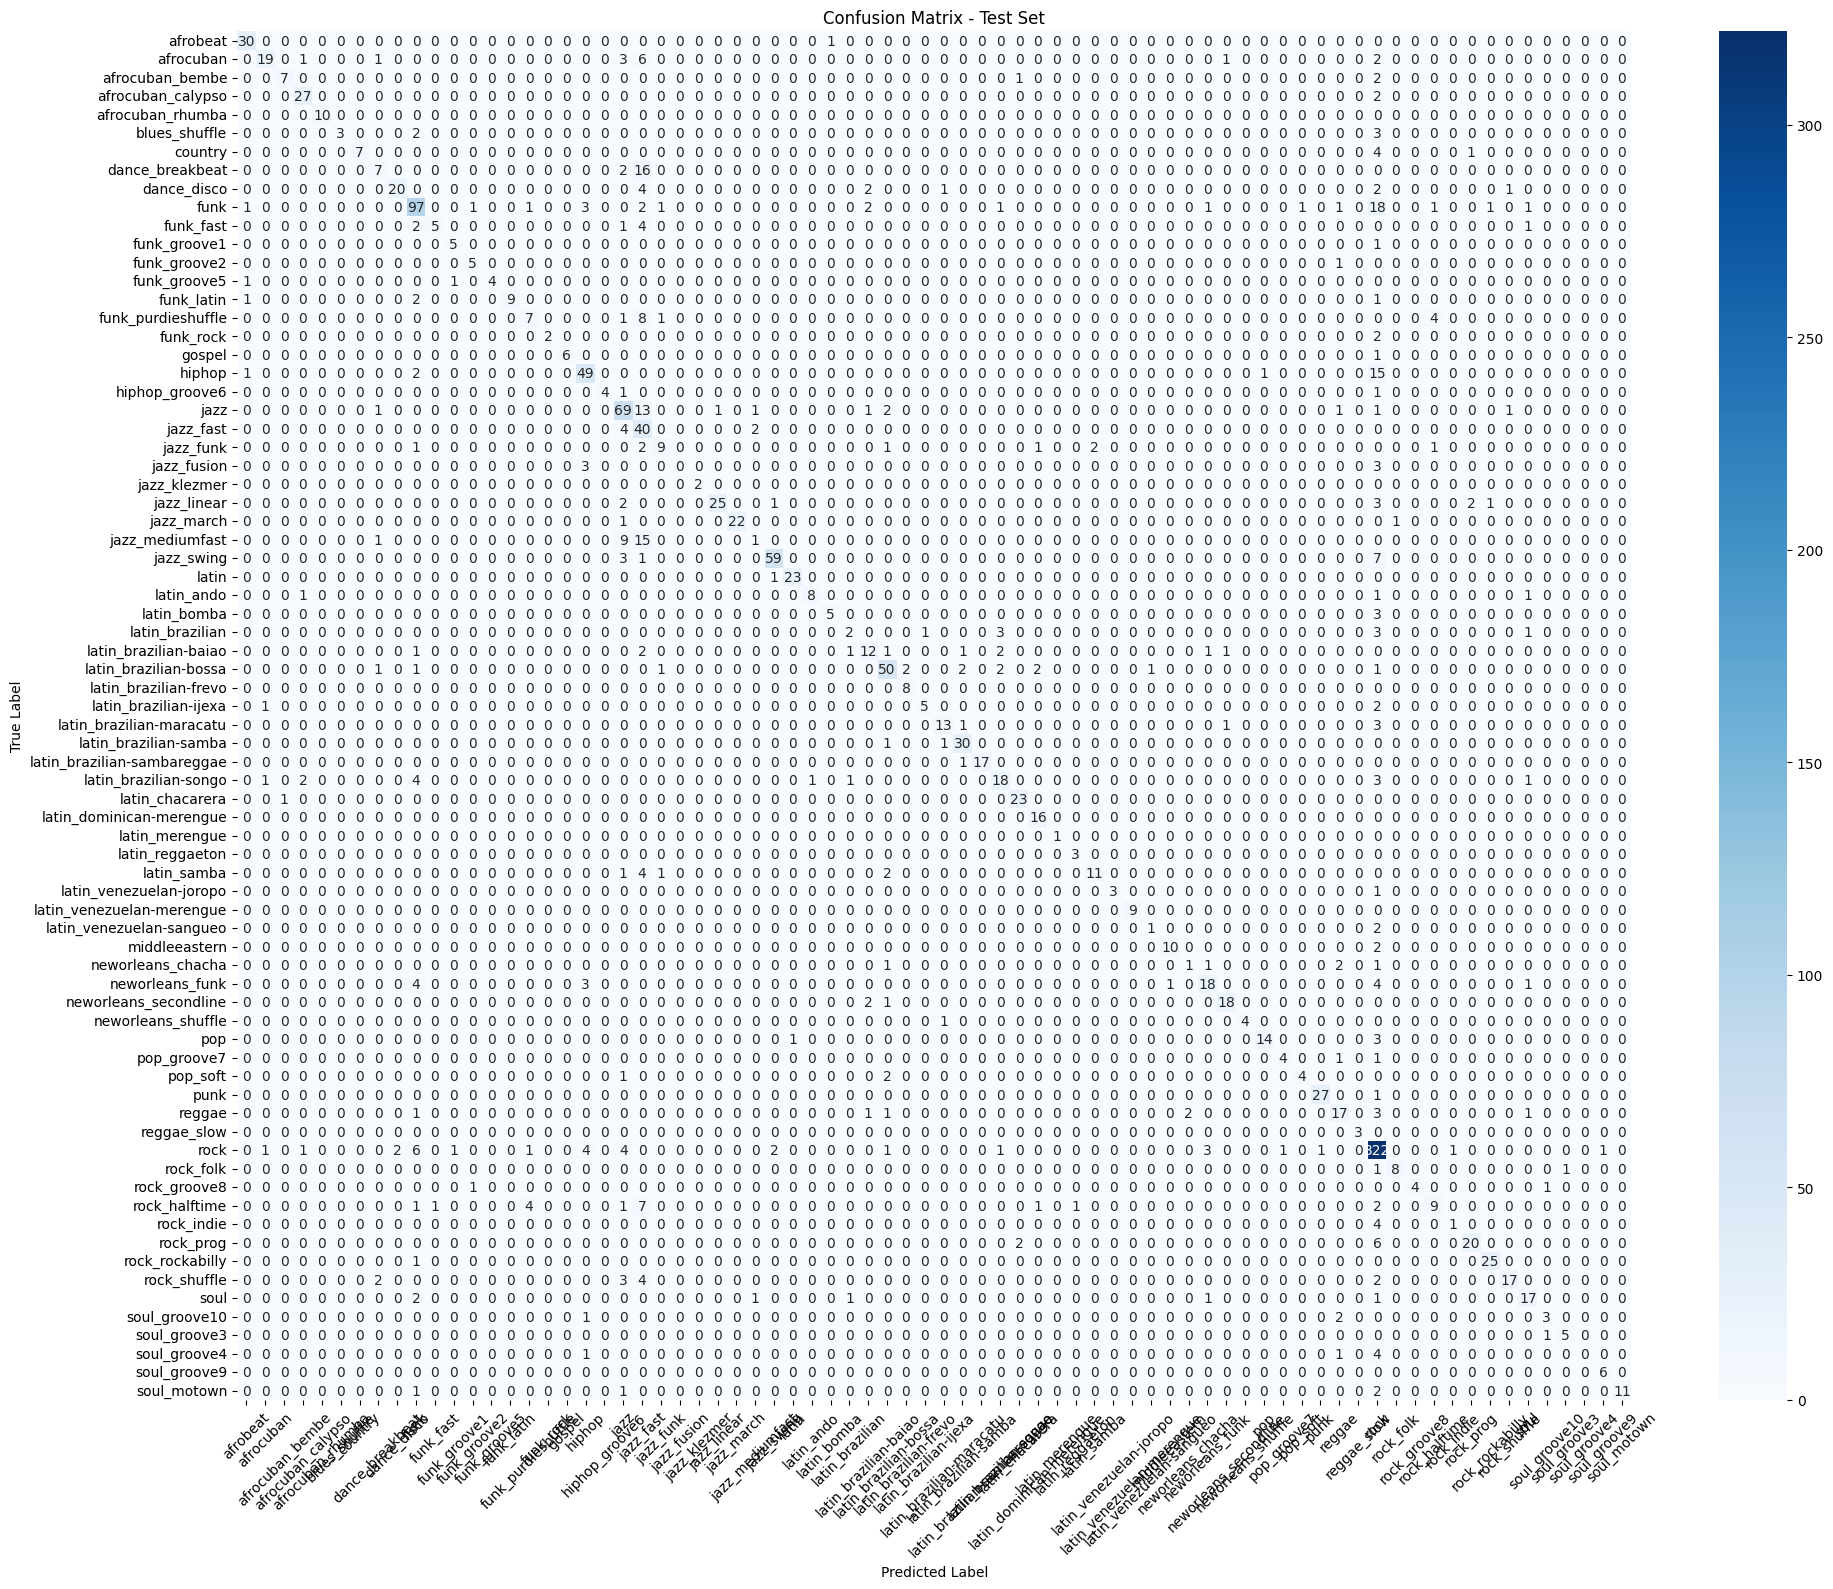

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:

                             precision    recall  f1-score   support

                   afrobeat       0.88      0.97      0.92        31
                  afrocuban       0.86      0.58      0.69        33
            afrocuban_bembe       0.88      0.70      0.78        10
          afrocuban_calypso       0.84      0.93      0.89        29
           afrocuban_rhumba       1.00      1.00      1.00        10
              blues_shuffle       1.00      0.38      0.55         8
                    country       1.00      0.58      0.74        12
            dance_breakbeat       0.54      0.28      0.37        25
                dance_disco       0.91      0.67      0.77        30
                       funk       0.76      0.73      0.74       133
                  funk_fast       0.83      0.38      0.53        13
               funk_groove1       0.71      0.83      0.77         6
               funk_groove2       0.71      0.83      0.77         6
         

In [ ]:
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# === Inference and metric aggregation
all_preds = []
all_labels = []
all_probs = []

model.eval()
with torch.no_grad():
    for features, labels, _ in test_loader:
        features = features.to(device)
        outputs = model(features)

        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# === Setup
idx_to_class = test_dataset.idx_to_class
class_names = [idx_to_class[i] for i in sorted(idx_to_class)]
num_classes = len(class_names)

# === Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("confusion_matrix_test.png", dpi=500)
plt.show()

# === Standard Classification Report
report_str = classification_report(all_labels, all_preds, target_names=class_names, digits=2)
print("Classification Report:\n")
print(report_str)

# === Overall Accuracy
accuracy = np.mean(all_preds == all_labels) * 100
print(f"\nOverall Accuracy: {accuracy:.2f}%")

# === Mean Average Precision (mAP) and AUC (One-vs-Rest)
binary_labels = np.eye(num_classes)[all_labels]  # one-hot encoding
mAP = average_precision_score(binary_labels, all_probs, average="macro")
AUC = roc_auc_score(binary_labels, all_probs, average="macro")

print(f"Mean Average Precision (mAP): {mAP:.4f}")
print(f"Area Under Curve (AUC): {AUC:.4f}")

# === Per-Class Detailed Metrics
print("\nPer-class Metrics:\n")
for i, class_name in enumerate(class_names):
    y_true_binary = binary_labels[:, i]
    y_pred_binary = all_probs[:, i]

    precision = precision_score(all_labels == i, all_preds == i, zero_division=0)
    recall = recall_score(all_labels == i, all_preds == i, zero_division=0)
    f1 = f1_score(all_labels == i, all_preds == i, zero_division=0)
    ap = average_precision_score(y_true_binary, y_pred_binary)
    auc = roc_auc_score(y_true_binary, y_pred_binary)
    support = np.sum(all_labels == i)

    print(f"{class_name}:")
    print(f"  Precision: {precision * 100:.2f}%")
    print(f"  Recall: {recall * 100:.2f}%")
    print(f"  F1-score: {f1 * 100:.2f}%")
    print(f"  mAP: {ap:.4f}")
    print(f"  AUC: {auc:.4f}")
    print(f"  Support: {support}")
    print("")
